# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage as ski


In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print(X_train.shape)
print(y_test.shape)

(39209, 32, 32, 3)
(12630,)


In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Number of columns 4
Number of rows 10


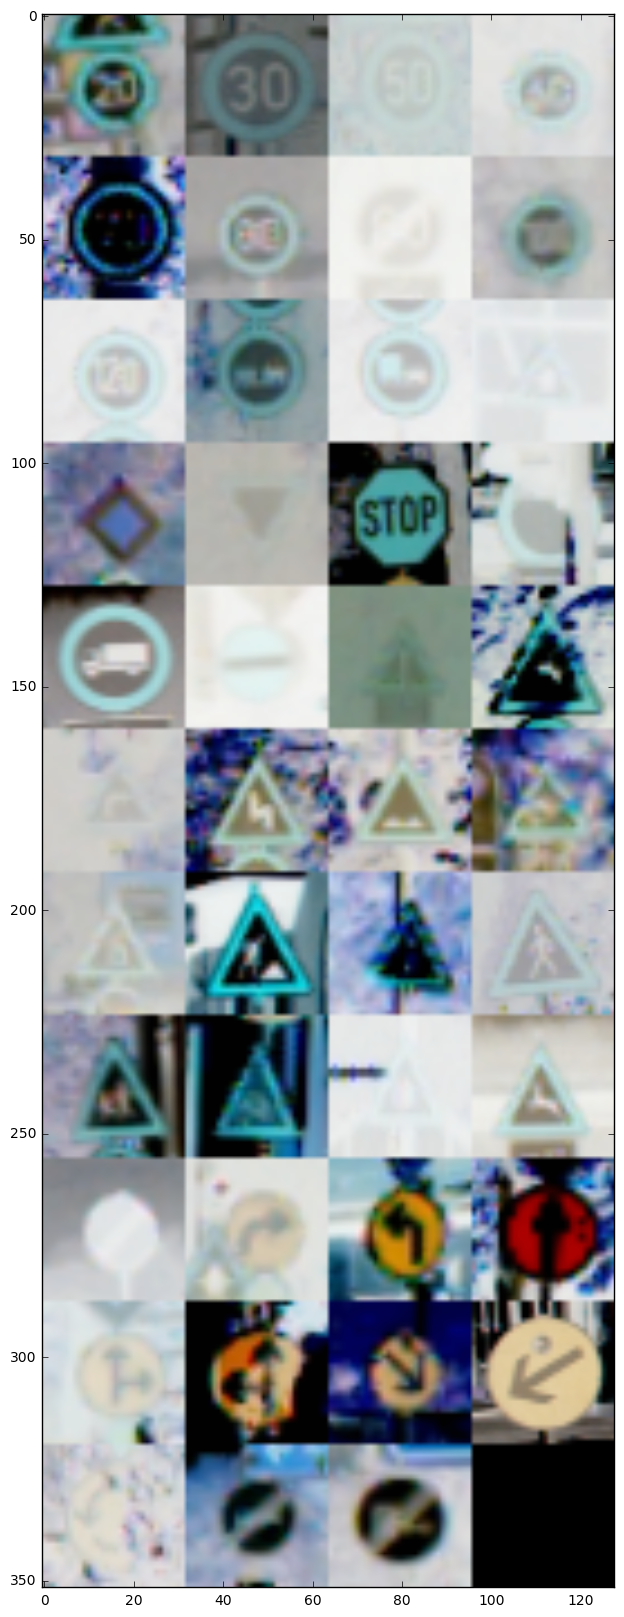

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

## VIEW SUMMARY OF TYPES OF IMAGES BEING CLASSIFIED
num_cols = 4
num_rows = int(n_classes/4.0)
print("Number of columns",num_cols)
print("Number of rows", num_rows)

img_ix = [np.amin(np.where(y_train==x)) for x in np.unique(y_train)]

all_imgs = [[None]*num_cols]*(num_rows+1)
all_imgs = np.empty(((num_rows+1)*32, num_cols*32, 3))
i=1
row_ix = 0
col_ix = 0
#fig = plt.figure()
for img in img_ix:
    row_start = row_ix*32
    row_end = row_start + 32
    col_start = col_ix*32
    col_end = col_start + 32
   # print(row_start, row_end, col_start, col_end)
    all_imgs[row_start:row_end, col_start:col_end, 0:3] = X_train[img]
    #all_imgs[row_ix][col_ix] = X_train[img]
    if col_ix==3:
        row_ix = row_ix + 1
        col_ix = 0
    else:
        col_ix = col_ix + 1
    
#plt.imshow(all_imgs)
dpi=80
xpixels = 1624
ypixels = 600
fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
plt.imshow(all_imgs)
plt.show()


1


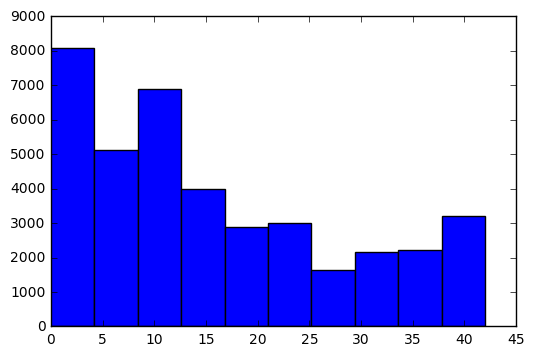

In [5]:
# VIEW HISTOGRAM OF TRAINING CLASSES

print(y_train[1000])
plt.hist(y_train)
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from sklearn import pipeline as skpipe
from skimage import color
#color conversion
def to_grayscale(img):
    return color.rgb2gray(img)

def to_yuv(img):
    return color.rgb2hsv(img)

def standardize_image(img):
    #assume grayscale only for now
    img = (img - np.mean(img)) / np.std(img)
    return img

#preprocess_pipe = [to_grayscale, standardize_image]
preprocess_pipe = [to_grayscale]

def preprocess_img(proc_img):
    for func in preprocess_pipe:
        proc_img = func(proc_img)
    return proc_img


In [7]:
#preprocess images using the preprocessing pipeline

single_proc = preprocess_img(X_train[0])
single_image_shape = single_proc.shape

# preprocess training set
final_shape = (X_train.shape[0],) + single_image_shape
X_train_proc = np.empty(final_shape)
for i in range(0, X_train.shape[0]):
    X_train_proc[i,:,:] = preprocess_img(X_train[i,:,:,:])

# preprocess test set
final_shape = (X_test.shape[0],) + single_image_shape
X_test_proc = np.empty(final_shape)
for i in range(0, X_test.shape[0]):
    X_test_proc[i,:,:] = preprocess_img(X_train[i,:,:,:])



(12630, 32, 32)


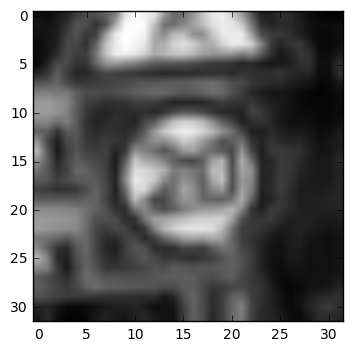

In [8]:
print(X_test_proc.shape)
plt.imshow(X_train_proc[0],cmap='gray')
plt.show()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [9]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train, y_train, test_size=0.20, random_state=42)


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [10]:
import random
from sklearn import preprocessing
### Define your architecture here.
### Feel free to use as many code cells as needed.

# setup helper function to get batch

def get_batch_idxs(train_set_length, batch_size):
    #first shuffle all ix
    print("train_set lenght: ", train_set_length)
    print("batch_size: ", batch_size)
    rand_idx = list(range(0, train_set_length-1))
    random.shuffle(rand_idx)
    result = [(i,i+batch_size) for i in range(0,len(rand_idx)-batch_size,batch_size)]
    return [rand_idx, result]

def get_serial_batch_idxs(train_set_length, batch_size):
    result = [(i,i+batch_size) for i in range(0,(train_set_length)-batch_size,batch_size)]
#     random.shuffle(result)
    return result

def one_hot_encode(y_data, n_classes):
    ohc = preprocessing.OneHotEncoder()
    y_ohc = ohc.fit(np.arange(n_classes).reshape(-1, 1))
    y_labels = y_ohc.transform(y_data.reshape(-1, 1)).toarray()
    return y_labels
   

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [11]:
# Parameters
learning_rate = 0.01
batch_size = 128
training_epochs = 15

#n_input = 784  # MNIST data input (Shape: 28*28)
#n_classes = 10  # MNIST total classes (0-9 digits)

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

# Store layers weight & bias
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_width['layer_1']], stddev=0.01)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']], stddev=0.01)),
    'layer_3': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_2'], layer_width['layer_3']],stddev=0.01)),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [8192, layer_width['fully_connected']],stddev=0.01)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes],stddev=0.01))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

# Create model
def conv_net(x, weights, biases):
    #image = tf.reshape(x, [-1,32,32,1])
    # Layer 1
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)

#     # Layer 2
#     conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
#     conv2 = maxpool2d(conv2)

#     # Layer 3
#     conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
#     conv3 = maxpool2d(conv3)

    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv1,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.relu(fc1)

    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# tf Graph input
x = tf.placeholder("float", [None, single_image_shape[0], single_image_shape[1],3])
y = tf.placeholder("float", [None, n_classes])

logits = conv_net(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer()\
    .minimize(cost)


In [12]:
ix_list = [1,4,5,6]
print(X_train[ix_list].shape)
print(X_train_s[1:10000].shape[0])
batch_idx_list = get_serial_batch_idxs(X_train_s[1:5000].shape[0], batch_size)        # Loop over all batches
print(batch_idx_list)   

print(y_train_s[0:5])
print(np.where(one_hot_encode(y_train_s[0:5],n_classes)))

(4, 32, 32, 3)
9999
[(0, 128), (128, 256), (256, 384), (384, 512), (512, 640), (640, 768), (768, 896), (896, 1024), (1024, 1152), (1152, 1280), (1280, 1408), (1408, 1536), (1536, 1664), (1664, 1792), (1792, 1920), (1920, 2048), (2048, 2176), (2176, 2304), (2304, 2432), (2432, 2560), (2560, 2688), (2688, 2816), (2816, 2944), (2944, 3072), (3072, 3200), (3200, 3328), (3328, 3456), (3456, 3584), (3584, 3712), (3712, 3840), (3840, 3968), (3968, 4096), (4096, 4224), (4224, 4352), (4352, 4480), (4480, 4608), (4608, 4736), (4736, 4864), (4864, 4992)]
[36 28  2  5 26]
(array([0, 1, 2, 3, 4]), array([36, 28,  2,  5, 26]))


In [13]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Test model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))    

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        batch_idx_list = get_serial_batch_idxs(X_train_s.shape[0], batch_size)        # Loop over all batches
        for i in batch_idx_list:
            batch_start = i[0]
            batch_end = i[1]
            batch_x = X_train_s[batch_start:batch_end]
            batch_y = y_train_s[batch_start:batch_end]
            batch_y = one_hot_encode(batch_y, n_classes)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        train_accuracy = accuracy.eval(feed_dict={
                              x:X_valid_s, y: one_hot_encode(y_valid_s,n_classes)})
        print("batch training accuracy %g"%(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={
                              x:X_test, y: one_hot_encode(y_test,n_classes)})
        print("batch testing accuracy %g"%(test_accuracy))
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    print("Optimization Finished!")


Instructions for updating:
Use `tf.global_variables_initializer` instead.
batch training accuracy 0.868146
batch testing accuracy 0.78179
Epoch: 0001 cost= 0.355400771
batch training accuracy 0.918516
batch testing accuracy 0.817736
Epoch: 0002 cost= 0.146425009
batch training accuracy 0.944147
batch testing accuracy 0.850436
Epoch: 0003 cost= 0.120807633
batch training accuracy 0.936241
batch testing accuracy 0.834442
Epoch: 0004 cost= 0.072911941
batch training accuracy 0.942872
batch testing accuracy 0.854474
Epoch: 0005 cost= 0.072129153
batch training accuracy 0.939557
batch testing accuracy 0.839509
Epoch: 0006 cost= 0.081986405
batch training accuracy 0.962637
batch testing accuracy 0.855662
Epoch: 0007 cost= 0.033403620
batch training accuracy 0.952818
batch testing accuracy 0.851465
Epoch: 0008 cost= 0.031654540
batch training accuracy 0.957282
batch testing accuracy 0.861125
Epoch: 0009 cost= 0.027455026
batch training accuracy 0.954094
batch testing accuracy 0.842281
Epoch: 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Optimizer: AdamOptimizer which is modern and can manage to train without providing defaults for learning rate and other parameters. 
Batch Size: 128
Epochs: 15
Single layer neural net with 32 units with 5x5x3 Kernels. I used Relu un 

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.